# Data Augmentation for Object Detection

Augment the images to create more training data for Yolo. This should improve the performance of the network significantly. 

## Bearbeiter 

* Daniel Bruckner

In [1]:
import cv2
import imgaug as ia
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


from skimage import io
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%matplotlib inline

## Augmentation with one sample image

In [2]:
annotation_file_path = '/home/db131/data/obj_det_data/yolo_training_data.txt'

Read and parse the lines in the annotation file to get an image path to an image to load and try some augmentation methods on.

In [3]:
ann_file = open(annotation_file_path, 'r') 
ann_file_lines = ann_file.readlines() 
  
first_line = ann_file_lines[5].strip()
first_img_path = first_line.split(' ')[0]
print("Image path = {}".format(first_img_path))

Image path = /home/db131/data/obj_det_data/all/160432.jpg


Parse the bounding box data

In [4]:
first_bbox_coords = np.array(first_line.split(' ')[1].split(',')[:-1]).astype(np.int32)
first_bbox_class = int(first_line.split(' ')[1].split(',')[-1])

print("Bbox = {}\nClass = {}".format(first_bbox_coords, first_bbox_class))

Bbox = [ 475   34 1222  669]
Class = 1


Show image with bounding box drawn on it

In [5]:
class_mapping = {1: 'Open', 0: 'Closed'}

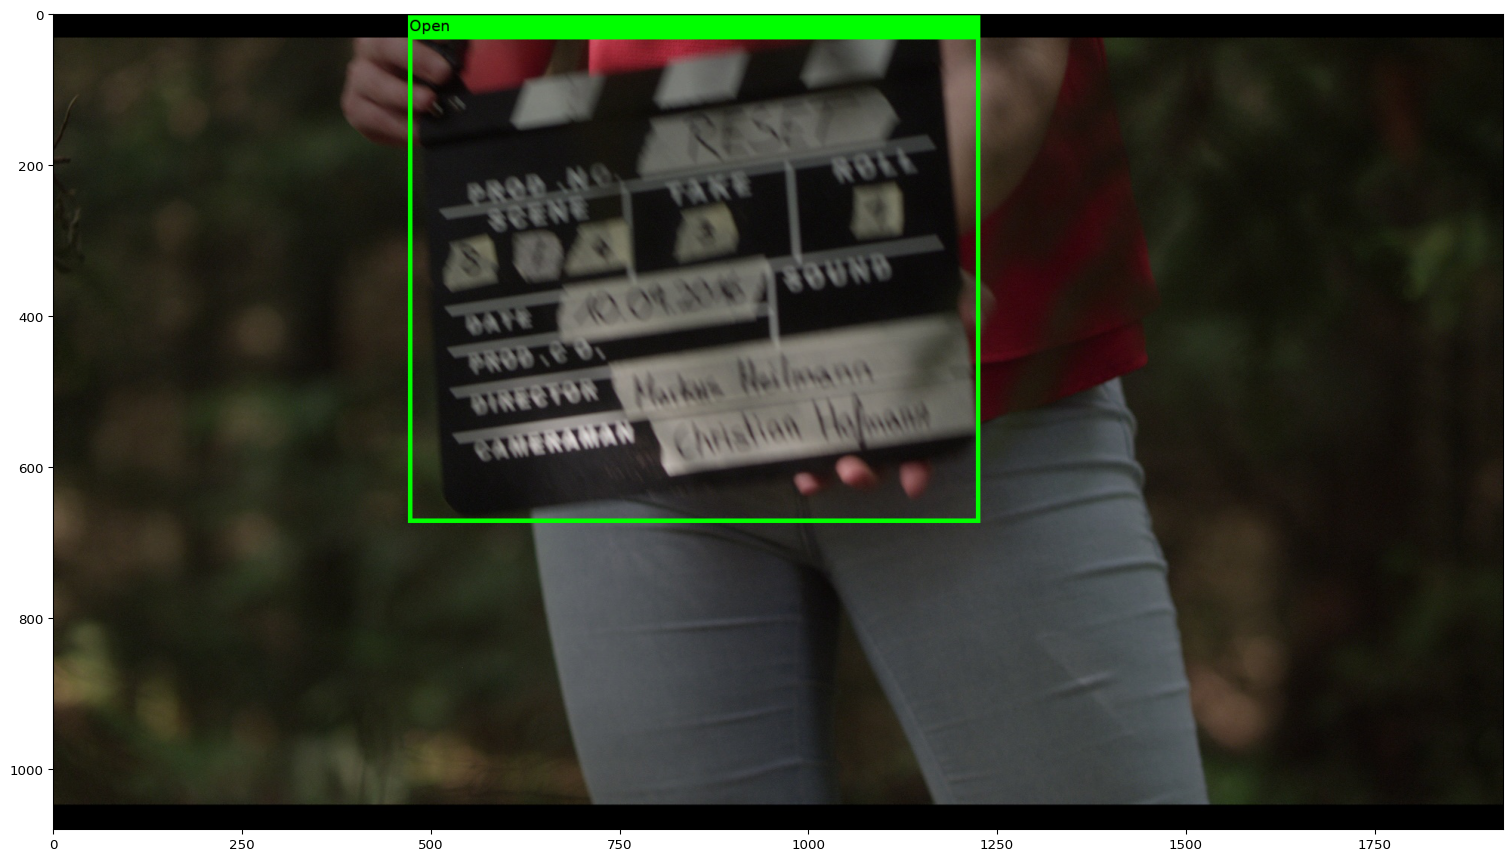

In [6]:
first_image = io.imread(first_img_path)

bbs = BoundingBoxesOnImage([
    BoundingBox(x1=first_bbox_coords[0], x2=first_bbox_coords[2],
                y1=first_bbox_coords[1], y2=first_bbox_coords[3]),
    ], shape=first_image.shape)

bbs[0].label = class_mapping[first_bbox_class]

ia.imshow(bbs.draw_on_image(first_image, size=6))

### Apply augmentations

There are a couple of transformations that aren't present in the `imgaug` library, namely augmentations constrained to the bounding box area only. So, we will implement them here:

#### Rotation inside the bounding box

In [7]:
from PIL import Image

In [8]:
def bbox_rotation(degrees, img, bbox):
    image_pil = Image.fromarray(img)
    sub_image = image_pil.crop(box=bbox).rotate(degrees)
    image_pil.paste(sub_image, box=bbox)
    return np.array(image_pil)

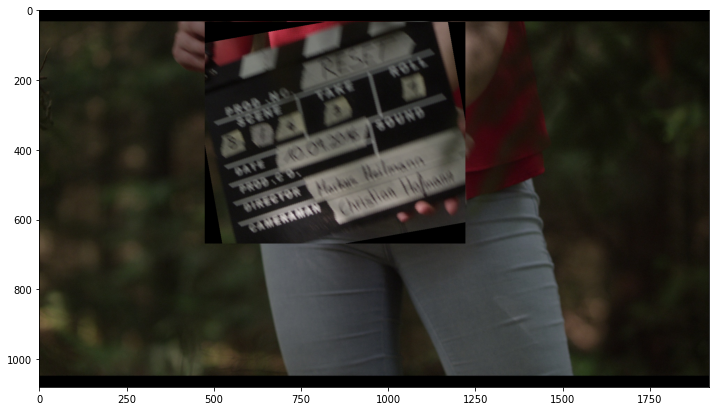

In [9]:
plt.figure(figsize=(12, 15))
plt.imshow(bbox_rotation(10, first_image, first_bbox_coords))

#### Horizintal Flip inside of the bounding box

In [10]:
def bbox_horizontal_flip(image, bbox):
    image_pil = Image.fromarray(image)
    sub_image = image_pil.crop(box=bbox).transpose(Image.FLIP_LEFT_RIGHT)
    image_pil.paste(sub_image, box=bbox)
    return np.array(image_pil)

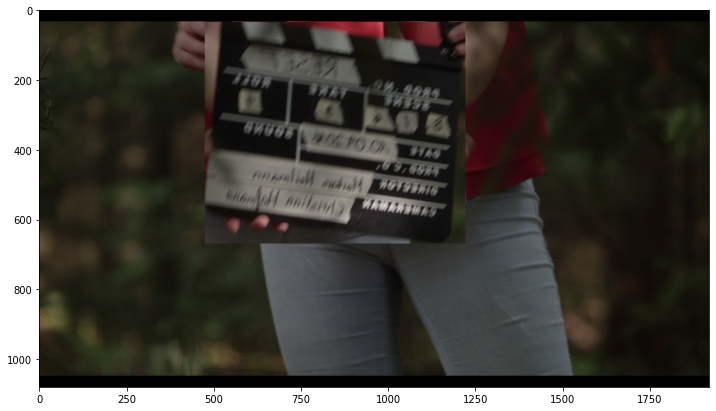

In [11]:
plt.figure(figsize=(12, 15))
plt.imshow(bbox_horizontal_flip(first_image, first_bbox_coords))

#### Vertical Flip inside of the bounding box

In [12]:
def bbox_vertical_flip(image, bbox):
    image_pil = Image.fromarray(image)
    sub_image = image_pil.crop(box=bbox).transpose(Image.FLIP_TOP_BOTTOM)
    image_pil.paste(sub_image, box=bbox)
    return np.array(image_pil)

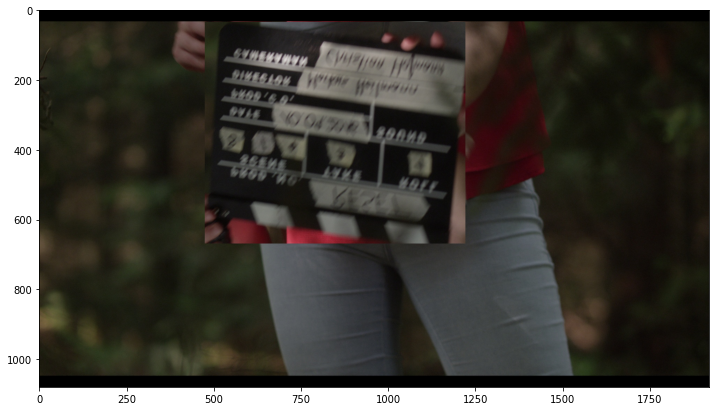

In [13]:
plt.figure(figsize=(12, 15))
plt.imshow(bbox_vertical_flip(first_image, first_bbox_coords))

In [14]:
from imgaug import augmenters as iaa
from skimage.exposure import equalize_hist
from skimage import img_as_int

#### Rotation of the image (and adjusting the bounding box)

Place a defined amount of random modification actions into one sequential array to multiply the amount of training data available.

In [15]:
def rotate_with_bbox(image, bbox, degrees):
    bbox = np.copy(bbox)
    
    seq = iaa.Sequential([
        iaa.geometric.Rotate(degrees)
    ])
    
    bbs = BoundingBoxesOnImage([
        BoundingBox(x1=bbox[0], x2=bbox[2],
                    y1=bbox[1], y2=bbox[3]),
    ], shape=image.shape)
    
    image_aug, bbs_aug = seq(image=first_image, bounding_boxes=bbs)
    
    bbox_aug = np.array([bbs_aug[0].x1, bbs_aug[0].y1, bbs_aug[0].x2, bbs_aug[0].y2])
    
    return image_aug, bbox_aug.astype(np.int32) 

#### Bounding box translation

Move the bounding box around the image for to achieve a better generalizability:

In [16]:
def box_translation(image_shape, bbox): 
    
    bbox = np.copy(bbox)
    
    factor_0 = 0.08
    factor_1 = 0.04
    
    y_translations = [image_shape[0] * (-1) * factor_0, 
                      image_shape[0] * (-1) * factor_1, 
                      0, 
                      image_shape[0] * factor_0, 
                      image_shape[0] * factor_1,]
    
    x_translations = [image_shape[1] * (-1) * factor_0, 
                      image_shape[1] * (-1) * factor_1, 
                      0, 
                      image_shape[1] * factor_0, 
                      image_shape[1] * factor_1,]
    
    if np.random.choice([True, False]):

        translation = np.random.choice(x_translations)
        bbox[0] += translation
        bbox[2] += translation        
    else:
        translation = np.random.choice(y_translations)
        bbox[1] += translation
        bbox[3] += translation
    
    return bbox

...And check if it works:

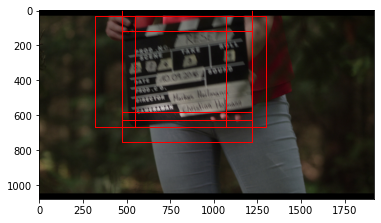

In [17]:
fig,ax = plt.subplots(1)
ax.imshow(first_image)

# Create a Rectangle patch

for i in range(10):
    bbox_aug = box_translation(first_image.shape, first_bbox_coords)
    
    width = bbox_aug[2] - bbox_aug[0]
    height = bbox_aug[3] - bbox_aug[1]

    rect = patches.Rectangle((bbox_aug[0], bbox_aug[1]), 
                             width, height, linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

Make a bounding box translation and make sure that the resulting bounding boxes don't grow outside of the image borders:

In [18]:
def cut_single_value_to_borders(maximum, val):
    if val < 0:
        return 0
    elif val > maximum:
        return maximum
    else:
        return val

def cut_to_borders(image_shape, bbox):
    bbox[0] = cut_single_value_to_borders(image_shape[1], bbox[0])
    bbox[1] = cut_single_value_to_borders(image_shape[0], bbox[1])
    bbox[2] = cut_single_value_to_borders(image_shape[1], bbox[2])
    bbox[3] = cut_single_value_to_borders(image_shape[0], bbox[3])
    
    return bbox

#### Image Blur

Sometimes the camera isn't focuesed yet when the shot starts. This is meant to train the model to still detect the clapperboard.

In [19]:
from skimage.filters import gaussian

In [20]:
def blur_image(image, max_sigma=20):
    return gaussian(image, np.random.randint(1, max_sigma, 1)[0])

Test if blurring works

/home/db131/miniconda3/envs/yolo-tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  


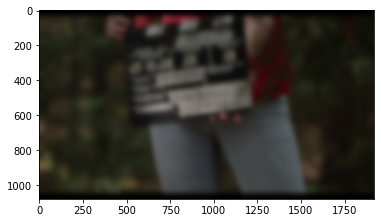

In [21]:
plt.imshow(blur_image(first_image))

... It works

#### Create an augmention policy

Chain all augmentation actions into one method:

In [22]:
import copy

In [23]:
def augment_image(image, bbox):
    image = copy.deepcopy(image)
    bbox = np.copy(bbox)
    
    rotations = [0, 5, 10, 15]
    policy = []
       
    # Vertical Flip inside of the bbox
    if np.random.choice([True, False]):
        image = bbox_horizontal_flip(image, bbox)
        policy.append('bbox_horizontal_flip')
    
    # Rotation inside of the bbox
    if np.random.choice([True, False]):
        image = bbox_rotation(np.random.choice(rotations), image, bbox)
        policy.append('bbox_rotation')
        
    # Histogram Equalization
    if np.random.choice([True, False]):
        image = equalize_hist(image)
        policy.append('equalize_hist')
        
    # BBox translation Yes/No
    if np.random.choice([True, False]):
        # X or Y translation
        bbox = box_translation(image.shape, bbox)
        policy.append('box_translation')

        
    if np.random.choice([True, False]):
        image = blur_image(image)
        policy.append('blur_image')
    
    if image.dtype == 'float64':
        image *= 255
        return image.astype(np.int32), bbox, policy
    else:
        return image, bbox, policy

Show what the augmentation does by applying a couple of actions on the previously loaded image:

/home/db131/miniconda3/envs/yolo-tensorflow/lib/python3.6/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/home/db131/miniconda3/envs/yolo-tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  


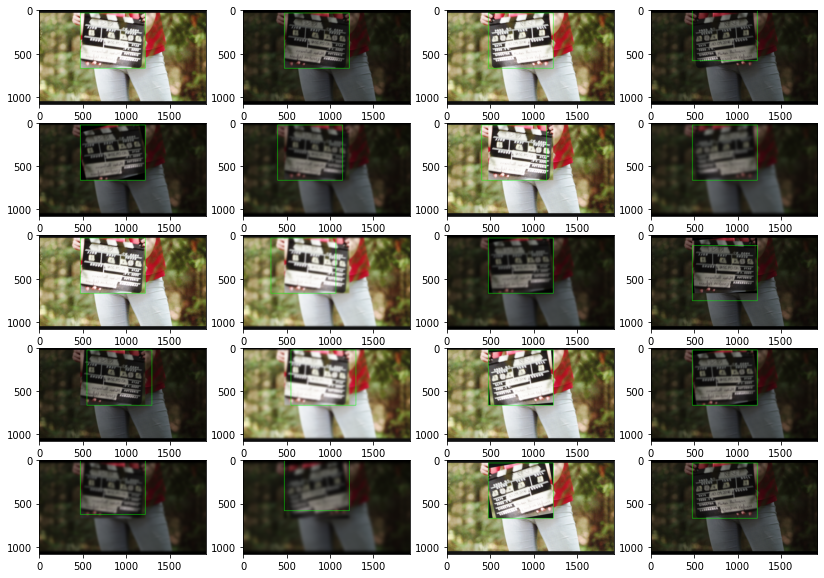

In [24]:
w=10
h=10
fig=plt.figure(figsize=(14, 10))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    image_aug, bbox_aug, _ = augment_image(first_image, first_bbox_coords)
    image_aug = copy.deepcopy(image_aug)
    cv2.rectangle(image_aug, (bbox_aug[0], bbox_aug[1]), (bbox_aug[2], bbox_aug[3]), (0,255,0), 4)

    fig.add_subplot(rows, columns, i)
    
    plt.imshow(image_aug)
plt.show()

### Saving the augmented images

In [25]:
import os
import glob

from tqdm import tqdm

Parse the lines from the annotation file:

In [26]:
def parse_line(line):
    img_path = line.split(' ')[0]
    bbox_coords = np.array(line.split(' ')[1].split(',')[:-1]).astype(np.float32).astype(np.int32)
    bbox_class = int(line.split(' ')[1].split(',')[-1])
    
    return img_path, bbox_coords, bbox_class

In [27]:
def create_line(img_path, bbox_coords, bbox_class):
    return '{} {},{},{},{},{}'.format(
        img_path, 
        bbox_coords[0], 
        bbox_coords[1],
        bbox_coords[2],
        bbox_coords[3],
        bbox_class
    )

Change the file name of the image so that we can understand it's an augmented file:

In [28]:
def change_img_name(img_path, augmentation_number):
    img_name = img_path.split('/')[-1]
    img_ending = img_name.split('.')[-1]
    img_prev = img_name.split('.')[0]
    
    return "{}_aug_{}.{}".format(img_prev, augmentation_number, img_ending)

Create a directory to save the images to if it doesn't already exist:

In [29]:
def create_directory(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [30]:
augmented_images_path = '/home/db131/data/obj_det_data/augmented'

In [31]:
create_directory(augmented_images_path)

Save the images to the directory and save the path to the files to an updated annotation file:

In [32]:
augmented_ann_path = '/home/db131/data/obj_det_data/augmented_data_annotations.txt'

Remove the augmentations file if it exists and create a new one

In [33]:
if not os.path.exists(augmented_ann_path):
    print('Creating annotations file from scratch')
    augmented_annotations_file = open(augmented_ann_path, 'a')
else:
    print('Creating new annotations file')
    os.remove(augmented_ann_path)
    augmented_annotations_file = open(augmented_ann_path, 'a')

Creating new annotations file


Remove all augmented images if any images exist:

In [34]:
if len(os.listdir(path=augmented_images_path)) > 0:
    print('Removing previously created images...')
    files = glob.glob(augmented_images_path + "/*")
    for f in files:
        os.remove(f)
    
    if len(os.listdir(path=augmented_images_path)) == 0:
        print('Done')

Removing previously created images...
Done


### Create Augmented images along with annotations

#### Create control mechanism to check if all the boxes are correct 

To make sure that everything works as expected, we have to check if the augmented bounding box is rouhly the size of the original bounding box. If it was significantly larger, that would that something indtroduced an error into the routine.

In [35]:
def get_bbox_area(bbox):
    width = bbox[2] - bbox[0]
    height = bbox[3] - bbox[1]
    
    return width * height

def get_surface_delta(bbox_1, bbox_2):
    surface_1 = get_bbox_area(bbox_1)
    surface_2 = get_bbox_area(bbox_2)
    
    return np.abs(surface_2 - surface_1)

Acutal augmentation routine:

In [ ]:
bbox_deltas = list()

augmentations_per_image = 8

for line in tqdm(ann_file_lines):
    img_path, bbox_coords, bbox_class = parse_line(line)
    img = io.imread(img_path)
    
    for i in range(augmentations_per_image):
        img_aug, bbox_aug, policy = augment_image(img, bbox_coords)
        bbox_aug = cut_to_borders(img_aug.shape, bbox_aug)
        
        surface_delta = get_surface_delta(bbox_aug, bbox_coords)
        bbox_deltas.append([line, surface_delta, bbox_aug, policy])
        
        img_name = change_img_name(img_path, i)
        
        new_path = os.path.join(augmented_images_path, img_name)
        new_line = create_line(new_path, bbox_aug, bbox_class)
        
        
        augmented_annotations_file.write(new_line + "\n")
        io.imsave(new_path, img_aug.astype(np.uint8))
        

  0%|          | 0/4244 [00:00<?, ?it/s]/home/db131/miniconda3/envs/yolo-tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  
  1%|          | 31/4244 [01:43<3:34:09,  3.05s/it]/home/db131/miniconda3/envs/yolo-tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: /home/db131/data/obj_det_data/augmented/216576_aug_1.jpg is a low contrast image
/home/db131/miniconda3/envs/yolo-tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: /home/db131/data/obj_det_data/augmented/216576_aug_2.jpg is a low contrast image
/home/db131/miniconda3/envs/yolo-tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: /home/db131/data/obj_det_data/augmented/216576_aug_3.jpg is a low contrast image
/home/db131/miniconda3/envs/yolo-tensorflow/lib/python3.6/site-